# Tải thư viện cần thiết

In [6]:
!pip install google-genai
!pip install evaluate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.3 MB/s eta 0:00:00


# SINH DATA

In [1]:
import pandas as pd
import json
import os
import torch
import numpy as np
import time
from google import genai
from google.colab import userdata
from google.genai import types
from google.genai.errors import APIError

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Khởi tạo Gemini Client (giữ nguyên)
GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")
client = genai.Client(api_key=GEMINI_API_KEY)

# Đường dẫn file đầu ra mới (đã cập nhật)
OUTPUT_FILE_PATH = "/content/drive/MyDrive/NLP/FinalTerm/Encoder_only/Datasets/synthetic_raw.csv"

# Vai trò hệ thống (giữ nguyên)
SYSTEM_ROLE = """Bạn là một **Chuyên gia tạo dữ liệu tổng hợp cho bình luận trên mạng xã hội tiếng Việt**.
Nhiệm vụ của bạn là tạo ra các bình luận mới, tự nhiên, đa dạng về chủ đề (xã hội, tin tức, giải trí, thể thao,...) và phong cách ngôn ngữ (tiếng lóng, viết tắt, ngôn ngữ thân mật trên mạng xã hội).
Mỗi bình luận phải được gán nhãn chính xác là **'toxic'** hoặc **'non-toxic'** dựa trên định nghĩa sau:
1.  **'toxic'**: Bình luận mang tính chất công kích, lăng mạ, đe dọa, xúc phạm cá nhân/tổ chức, kích động bạo lực, chứa ngôn từ thô tục, hoặc biểu lộ sự tiêu cực, thù ghét mạnh mẽ.
2.  **'non-toxic'**: Bình luận bình thường, tích cực, trung lập, bày tỏ quan điểm mang tính xây dựng, chia sẻ thông tin, hoặc phản hồi không gây hấn.
Bạn phải tuân thủ định dạng JSON đầu ra được yêu cầu.
"""

# Prompt tạo dữ liệu (giữ nguyên)
GENERATION_PROMPT_TEMPLATE = """
Dựa trên vai trò SYSTEM của bạn, hãy tạo ra 50 kịch bản dữ liệu mới.

Mỗi kịch bản cần chọn dữ liệu mới, ngẫu nhiên (chưa từng xuất hiện trong dữ liệu mẫu của tôi).

Đầu ra phải là một danh sách các đối tượng JSON, mỗi đối tượng chứa hai trường bắt buộc: **"text"** và **"label"**.
Ví dụ đầu ra:
[
  {
    "text": "Bạn nên tìm hiểu kỹ hơn trước khi phát biểu, thông tin này đã lỗi thời rồi.",
    "label": "non-toxic"
  },
  {
    "text": "Thằng ngu này chắc não để ngoài, nói toàn lời vô nghĩa!",
    "label": "toxic"
  },
  {
    "text": "Chúc mừng team A đã chiến thắng một cách xứng đáng.",
    "label": "non-toxic"
  }
]
"""

# Hàm sinh data đã sửa đổi
def generate_synthetic_data(num_batches, output_file_path, model_name='gemini-2.5-flash'):
    """
    Hàm gọi API để sinh dữ liệu synthetic theo lô (batch) và lưu từng lô thành công
    trực tiếp vào file CSV.

    Args:
        num_batches (int): Số lượng lô (batch) dữ liệu cần sinh.
        output_file_path (str): Đường dẫn đến file CSV để lưu dữ liệu.
        model_name (str): Tên mô hình LLM sẽ được gọi.

    Returns:
        list: Danh sách tổng hợp tất cả các bản ghi dữ liệu đã sinh.
    """
    global client
    all_synthetic_data = []

    # Kiểm tra xem file đã tồn tại chưa để quyết định có thêm header hay không
    file_exists = os.path.exists(output_file_path)

    contents = [
        {
            "role": "user",
            "parts": [{"text": GENERATION_PROMPT_TEMPLATE}]
        }
    ]

    for i in range(num_batches):
        print(f"\n--- Sinh lô thứ {i + 1} ---")
        try:
            # 1. Hàm gọi API để sinh dữ liệu synthetic theo lô (batch).
            response = client.models.generate_content(
                model=model_name,
                contents=contents,
                config={
                    "temperature": 0.8,
                    "system_instruction": SYSTEM_ROLE
                }
            )

            # 2. Xử lý phản hồi và trích xuất JSON
            raw_text = response.text.strip()

            # Xử lý loại bỏ các dấu bọc JSON (```json ... ```)
            import re
            raw_text = re.sub(r'^\s*```json\s*', '', raw_text, flags=re.IGNORECASE)
            raw_text = re.sub(r'\s*```\s*$', '', raw_text, flags=re.IGNORECASE)

            try:
                synthetic_records = json.loads(raw_text)
                print(f"Đã sinh thành công {len(synthetic_records)} bản ghi trong lô này.")

                # Xử lý lưu file cho lô thành công
                if synthetic_records:
                    # Chuyển list JSON thành DataFrame
                    df_batch = pd.DataFrame(synthetic_records)

                    # Kiểm tra xem đã có header chưa. Nếu file không tồn tại, thêm header.
                    # Nếu file đã tồn tại (từ batch trước), không thêm header.
                    include_header = not file_exists and i == 0 # Chỉ thêm header ở batch 1 nếu file chưa tồn tại

                    # Lưu file: chế độ 'a' (append)
                    df_batch.to_csv(output_file_path, mode='a', index=False, header=include_header)

                    # Cập nhật trạng thái file đã tồn tại sau khi lô đầu tiên được ghi thành công
                    file_exists = True

                    print(f"Đã lưu {len(df_batch)} bản ghi thành công.")

                    all_synthetic_data.extend(synthetic_records)

            except json.JSONDecodeError as e:
                print("Lỗi phân tích cú pháp JSON từ phản hồi của mô hình. Bỏ qua lô này.")
                print(f"Lỗi: {e}")
                print(f"Phản hồi thô (đã cắt): {raw_text[:200]}...")

        except Exception as e:
            print(f"Lỗi khi gọi API trong lô {i + 1}: {e}")

        # Tạm dừng một chút giữa các lô để tránh quá tải API
        time.sleep(1)

    print(f"\n--- HOÀN THÀNH QUÁ TRÌNH SINH DỮ LIỆU ---")
    print(f"Tổng cộng đã sinh được {len(all_synthetic_data)} bản ghi dữ liệu")
    return all_synthetic_data

# Sinh dữ liệu Synthetic
synthetic_records_list = generate_synthetic_data(num_batches=200, output_file_path=OUTPUT_FILE_PATH)


--- Sinh lô thứ 1 ---
Đã sinh thành công 50 bản ghi trong lô này.
Đã lưu 50 bản ghi thành công.

--- Sinh lô thứ 2 ---
Đã sinh thành công 50 bản ghi trong lô này.
Đã lưu 50 bản ghi thành công.

--- Sinh lô thứ 3 ---
Đã sinh thành công 50 bản ghi trong lô này.
Đã lưu 50 bản ghi thành công.

--- Sinh lô thứ 4 ---
Đã sinh thành công 50 bản ghi trong lô này.
Đã lưu 50 bản ghi thành công.

--- Sinh lô thứ 5 ---
Đã sinh thành công 50 bản ghi trong lô này.
Đã lưu 50 bản ghi thành công.

--- Sinh lô thứ 6 ---
Đã sinh thành công 50 bản ghi trong lô này.
Đã lưu 50 bản ghi thành công.

--- Sinh lô thứ 7 ---
Đã sinh thành công 50 bản ghi trong lô này.
Đã lưu 50 bản ghi thành công.

--- Sinh lô thứ 8 ---
Đã sinh thành công 50 bản ghi trong lô này.
Đã lưu 50 bản ghi thành công.

--- Sinh lô thứ 9 ---
Đã sinh thành công 50 bản ghi trong lô này.
Đã lưu 50 bản ghi thành công.

--- Sinh lô thứ 10 ---
Đã sinh thành công 50 bản ghi trong lô này.
Đã lưu 50 bản ghi thành công.

--- Sinh lô thứ 11 ---
Đã si

In [ ]:
# Định nghĩa đường dẫn file
OUTPUT_FILE_PATH = "/content/drive/MyDrive/NLP/FinalTerm/Encoder_only/Datasets/synthetic_raw.csv"
output = "/content/drive/MyDrive/NLP/FinalTerm/Encoder_only/Datasets/synthetic.csv"

if not os.path.exists(OUTPUT_FILE_PATH):
    print(f"Lỗi: Không tìm thấy file tại đường dẫn: {OUTPUT_FILE_PATH}")
else:
    try:
        # file chỉ có text và label
        df = pd.read_csv(OUTPUT_FILE_PATH)

        # Kiểm tra xem cột 'id' đã tồn tại chưa
        if 'id' in df.columns:
            print("Cột 'id' đã tồn tại trong file. Bỏ qua việc tạo mới ID.")
            # Đảm bảo thứ tự cột
            if df.columns.tolist() != ['id', 'text', 'label']:
                 df = df[['id', 'text', 'label']]
                 df.to_csv(OUTPUT_FILE_PATH, index=False)
                 print("Đã sắp xếp lại thứ tự cột thành: id, text, label.")
        else:
            # Tạo cột ID mới
            num_rows = len(df)

            # Tạo list ID từ CMT_00001 đến CMT_N
            # Sử dụng f-string và định dạng :05d để đảm bảo 5 chữ số có đệm số 0
            new_ids = [f"CMT_{i+1:05d}" for i in range(num_rows)]

            # Chèn cột 'id' vào vị trí đầu tiên (index 0)
            df.insert(0, 'id', new_ids)

            # Đảm bảo thứ tự cột: id, text, label (nếu có thêm cột nào khác)
            df = df[['id', 'text', 'label']]

            # Lưu DataFrame đã được bổ sung cột ID
            df.to_csv(output, index=False)
            print(f"Đã lưu file thành công")

            # Hiển thị 5 dòng đầu tiên để xác nhận
            print("\n--- 5 Hàng đầu tiên sau khi thêm cột ID ---")
            print(df.head())

    except Exception as e:
        print(f"Xảy ra lỗi trong quá trình xử lý file: {e}")

Đã lưu file thành công

--- 5 Hàng đầu tiên sau khi thêm cột ID ---
          id                                               text      label
0  CMT_00001  Hy vọng dự án mở rộng đường này sẽ giúp giảm k...  non-toxic
1  CMT_00002  Con nhỏ này hết thời rồi nên bày trò để gây ch...      toxic
2  CMT_00003  Trận đấu quá đỉnh! Công nhận thủ môn hôm nay b...  non-toxic
3  CMT_00004  Mấy đứa mù công nghệ thì đừng có lên tiếng phá...      toxic
4  CMT_00005  Đúng rồi, mình cũng thấy quan trọng là phải bi...  non-toxic


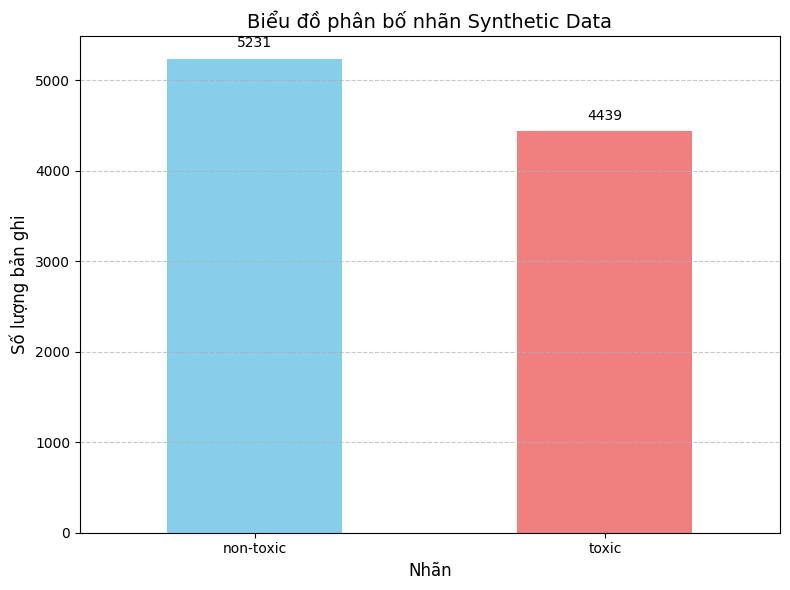

In [ ]:
import matplotlib.pyplot as plt
OUTPUT_FILE_PATH = "/content/drive/MyDrive/NLP/FinalTerm/Encoder_only/Datasets/synthetic_raw.csv"

try:
    df = pd.read_csv(OUTPUT_FILE_PATH)
    label_counts = df['label'].value_counts()
    plt.figure(figsize=(8, 6))
    label_counts.sort_values(ascending=False).plot(
        kind='bar',
        color=['skyblue', 'lightcoral']
    )

    plt.title('Biểu đồ phân bố nhãn Synthetic Data', fontsize=14)
    plt.xlabel('Nhãn', fontsize=12)
    plt.ylabel('Số lượng bản ghi', fontsize=12)

    for index, value in enumerate(label_counts.sort_values(ascending=False)):
        plt.text(index, value * 1.02, str(value), ha='center', va='bottom', fontsize=10)

    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    plot_file_name = 'label_distribution.png'
    plt.savefig(plot_file_name)

except Exception as e:
    print(f"Xảy ra lỗi trong quá trình tạo biểu đồ: {e}")

# Gộp file data

In [ ]:
FOLDER_PATH = "/content/drive/MyDrive/NLP/FinalTerm/Encoder_only/Datasets/"

# Danh sách tên các file synthetic data
file_names = [
    "Dataset01.csv",
    "synthetic.csv",
    "synthetic_nontoxic.csv"
]

# Tạo danh sách đường dẫn đầy đủ
file_paths = [os.path.join(FOLDER_PATH, f) for f in file_names]

In [ ]:
from pandas import concat

# tạo danh sách các DataFrame
list_of_dfs = []

for path in file_paths:
    print(f"Đang đọc file: {path}...")
    try:
        df = pd.read_csv(path)
        list_of_dfs.append(df)
        print(f"-> Đã đọc {len(df)} mẫu.")
    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file tại đường dẫn: {path}")

# Gộp tất cả các DataFrame lại thành một
# ignore_index=True đảm bảo index của DataFrame cuối cùng là liên tục (0, 1, 2, ...)
df_combined_synthetic = pd.concat(list_of_dfs, ignore_index=True)

print("\n--- KẾT QUẢ GỘP ---")
print(f"Tổng số mẫu synthetic data: {len(df_combined_synthetic)} mẫu.")
print(df_combined_synthetic.head())

OUTPUT_COMBINED_PATH = os.path.join(FOLDER_PATH, "synthetic_final.csv")
df_combined_synthetic.to_csv(OUTPUT_COMBINED_PATH, index=False)
print(f"\nĐã lưu tập dữ liệu cuối cùng tại: {OUTPUT_COMBINED_PATH}")

Đang đọc file: /content/drive/MyDrive/NLP/FinalTerm/Encoder_only/Datasets/Dataset01.csv...
-> Đã đọc 6694 mẫu.
Đang đọc file: /content/drive/MyDrive/NLP/FinalTerm/Encoder_only/Datasets/synthetic.csv...
-> Đã đọc 9670 mẫu.
Đang đọc file: /content/drive/MyDrive/NLP/FinalTerm/Encoder_only/Datasets/synthetic_nontoxic.csv...
-> Đã đọc 3000 mẫu.

--- KẾT QUẢ GỘP ---
Tổng số mẫu synthetic data: 19364 mẫu.
          id                                               text      label
0  CMT_00001                đẻ con ra mà không lo được chán v l      toxic
1  CMT_00002  tinh_thần dân_tộc cao nhà_sản_xuất chăm_sóc th...      toxic
2  CMT_00003  mình không giỏi fa ct nhưng khá nhạy_cảm với m...  non-toxic
3  CMT_00004                   mày cứ thử xem tao cứ sợ đi luôn      toxic
4  CMT_00005          chị ba vàng ngọc có cây đinh_mọc giữa dái  non-toxic

Đã lưu tập dữ liệu cuối cùng tại: /content/drive/MyDrive/NLP/FinalTerm/Encoder_only/Datasets/synthetic_final.csv


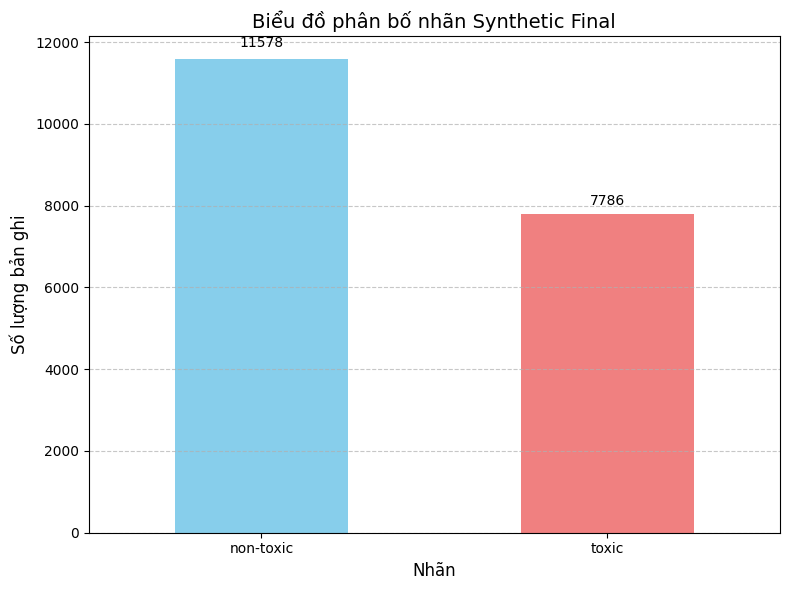

In [ ]:
import matplotlib.pyplot as plt
OUTPUT_FILE_PATH = "/content/drive/MyDrive/NLP/FinalTerm/Encoder_only/Datasets/synthetic_final.csv"

try:
    df = pd.read_csv(OUTPUT_FILE_PATH)
    label_counts = df['label'].value_counts()
    plt.figure(figsize=(8, 6))
    label_counts.sort_values(ascending=False).plot(
        kind='bar',
        color=['skyblue', 'lightcoral']
    )

    plt.title('Biểu đồ phân bố nhãn Synthetic Final', fontsize=14)
    plt.xlabel('Nhãn', fontsize=12)
    plt.ylabel('Số lượng bản ghi', fontsize=12)

    for index, value in enumerate(label_counts.sort_values(ascending=False)):
        plt.text(index, value * 1.02, str(value), ha='center', va='bottom', fontsize=10)

    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    plot_file_name = 'label_distribution.png'
    plt.savefig(plot_file_name)

except Exception as e:
    print(f"Xảy ra lỗi trong quá trình tạo biểu đồ: {e}")

# Thiết lập đường dẫn

In [3]:
import os
ROOT = '/content/drive/MyDrive/TDTU/HK7/Natural_Language_Processing/FinalTerm/'
BASE_DIR = os.path.join(ROOT, 'Encoder_only')
DATASETS = os.path.join(ROOT, 'Encoder_only', 'Datasets')
MODELS = os.path.join(DATASETS, 'Models')

tokenized_hf_data = os.path.join(DATASETS, 'tokenized_data')
classify_data = os.path.join(DATASETS, 'synthetic_final.csv')

# Tải và xử lý dữ liệu

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv(classify_data)
display(df.head())

print('\nSố lượng dữ liệu:', len(df))
print(df['label'].value_counts())

,id,text,label
0,CMT_00001,đẻ con ra mà không lo được chán v l,toxic
1,CMT_00002,tinh_thần dân_tộc cao nhà_sản_xuất chăm_sóc th...,toxic
2,CMT_00003,mình không giỏi fa ct nhưng khá nhạy_cảm với m...,non-toxic
3,CMT_00004,mày cứ thử xem tao cứ sợ đi luôn,toxic
4,CMT_00005,chị ba vàng ngọc có cây đinh_mọc giữa dái,non-toxic



Số lượng dữ liệu: 19364
label
non-toxic    11578
toxic         7786
Name: count, dtype: int64


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv(classify_data)
display(df.head())

print('\nSố lượng dữ liệu:', len(df))
print(df['label'].value_counts())

,id,text,label
0,CMT_00001,đẻ con ra mà không lo được chán v l,toxic
1,CMT_00002,tinh_thần dân_tộc cao nhà_sản_xuất chăm_sóc th...,toxic
2,CMT_00003,mình không giỏi fa ct nhưng khá nhạy_cảm với m...,non-toxic
3,CMT_00004,mày cứ thử xem tao cứ sợ đi luôn,toxic
4,CMT_00005,chị ba vàng ngọc có cây đinh_mọc giữa dái,non-toxic



Số lượng dữ liệu: 19364
label
non-toxic    11578
toxic         7786
Name: count, dtype: int64


In [ ]:
LABEL_MAPPING = {
    'toxic': 0,
    'non-toxic': 1
}

df['label'] = df['label'].map(LABEL_MAPPING)
display(df.head())

,id,text,label
0,CMT_00001,đẻ con ra mà không lo được chán v l,0
1,CMT_00002,tinh_thần dân_tộc cao nhà_sản_xuất chăm_sóc th...,0
2,CMT_00003,mình không giỏi fa ct nhưng khá nhạy_cảm với m...,1
3,CMT_00004,mày cứ thử xem tao cứ sợ đi luôn,0
4,CMT_00005,chị ba vàng ngọc có cây đinh_mọc giữa dái,1


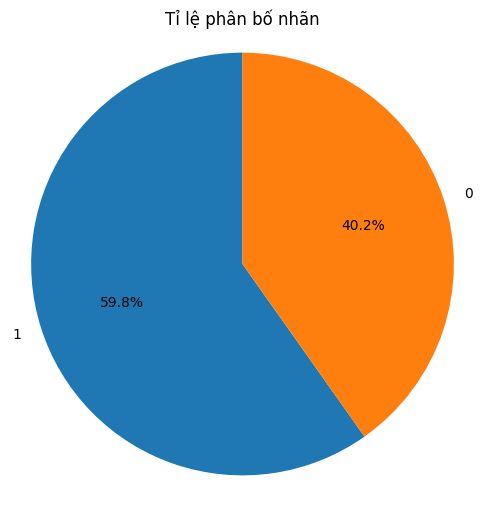

In [ ]:
import matplotlib.pyplot as plt
label_counts = df['label'].value_counts()

# Vẽ biểu đồ tròn
plt.figure(figsize=(6,6))
plt.pie(
    label_counts,
    labels=label_counts.index,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Tỉ lệ phân bố nhãn')
plt.axis('equal')  # đảm bảo hình tròn
plt.show()

# Chia data

In [ ]:
# Chia train 80% và phần còn lại 20%
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

# Chia tiếp valid và test (mỗi cái 10%)
valid_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["label"],
    random_state=42
)

In [ ]:
from datasets import Dataset

train_ds = Dataset.from_pandas(train_df)
valid_ds = Dataset.from_pandas(valid_df)
test_ds = Dataset.from_pandas(test_df)

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

def encode_batch(samples):
    return tokenizer(
        samples["text"],
        truncation=True,
        max_length=256,
        padding="max_length"
    )


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
# 1) Tokenize từng split
train_ds = train_ds.map(encode_batch, batched=True)
valid_ds = valid_ds.map(encode_batch, batched=True)
test_ds = test_ds.map(encode_batch, batched=True)

# 2) Loại bỏ các cột không cần thiết (id/text)
remove_cols = [col for col in train_ds.column_names if col not in ["label", "input_ids", "attention_mask"]]
train_ds = train_ds.remove_columns(remove_cols)
valid_ds = valid_ds.remove_columns(remove_cols)
test_ds = test_ds.remove_columns(remove_cols)

# 3) Gom vào DatasetDict
from datasets import DatasetDict

tokenized_datasets = DatasetDict({
    "train": train_ds,
    "valid": valid_ds,
    "test": test_ds
})

# 4) Lưu thành 1 thư mục duy nhất
tokenized_datasets.save_to_disk(tokenized_hf_data)

print(f"Saved to directory: {tokenized_hf_data}")


Map:   0%|          | 0/15491 [00:00<?, ? examples/s]

Map:   0%|          | 0/1936 [00:00<?, ? examples/s]

Map:   0%|          | 0/1937 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/15491 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1936 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1937 [00:00<?, ? examples/s]

Saved to directory: /content/drive/MyDrive/NLP/FinalTerm/Encoder_only/Datasets/tokenized_data


# LOAD DATA

In [ ]:
from datasets import load_from_disk

tokenized_datasets = load_from_disk(tokenized_hf_data)
train_ds = tokenized_datasets["train"]
valid_ds = tokenized_datasets["valid"]
test_ds = tokenized_datasets["test"]

# Cấu hình mô hình

In [7]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
import evaluate
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

In [ ]:
model_name = "vinai/phobert-large"   # "vinai/phobert-base"

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,  # toxic / non-toxic,
    problem_type="single_label_classification"
)

config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.48G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(eval_pred):
    """
    Tính toán các metrics cho phân loại nhị phân

    Args:
        eval_pred: Tuple (predictions, labels)

    Returns:
        dict: Dictionary chứa các metrics
    """
    predictions, labels = eval_pred

    # Convert logits to predicted class
    preds = np.argmax(predictions, axis=1)

    # Tính các metrics cơ bản
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary', pos_label=1
    )

    # Thêm metrics cho từng class
    precision_per_class, recall_per_class, f1_per_class, support = \
        precision_recall_fscore_support(labels, preds, average=None)

    # Confusion matrix
    cm = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cm.ravel()

    # Specificity (True Negative Rate)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    return {
        # Overall metrics
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "specificity": specificity,

        # Per-class metrics (class 0: non-toxic, class 1: toxic)
        "precision_class_0": precision_per_class[0],
        "recall_class_0": recall_per_class[0],
        "f1_class_0": f1_per_class[0],

        "precision_class_1": precision_per_class[1],
        "recall_class_1": recall_per_class[1],
        "f1_class_1": f1_per_class[1],

        # Confusion matrix elements
        "true_negative": int(tn),
        "false_positive": int(fp),
        "false_negative": int(fn),
        "true_positive": int(tp),
    }

In [ ]:
training_args = TrainingArguments(
    # Đường dẫn output
    output_dir=MODELS,

    # Training hyperparameters
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    warmup_ratio=0.1,

    # Optimization
    fp16=True,
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,

    # Evaluation & Saving
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,

    # Logging
    logging_dir=MODELS,
    logging_steps=10,
    report_to="none",

    # Misc
    seed=42,
    save_total_limit=2,  # Chỉ giữ 2 checkpoint tốt nhất
    push_to_hub=False,
)

# Training

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=3
        )
    ]
)

model.safetensors:   0%|          | 0.00/1.48G [00:00<?, ?B/s]

In [ ]:
# Train model
train_result = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Specificity,Precision Class 0,Recall Class 0,F1 Class 0,Precision Class 1,Recall Class 1,F1 Class 1,True Negative,False Positive,False Negative,True Positive
1,0.207000,0.148315,0.940599,0.944587,0.956822,0.950665,0.916452,0.934469,0.916452,0.925373,0.944587,0.956822,0.950665,713,65,50,1108
2,0.104600,0.179402,0.957645,0.949082,0.981865,0.965195,0.921594,0.971545,0.921594,0.945910,0.949082,0.981865,0.965195,717,61,21,1137
3,0.116800,0.169724,0.956095,0.959726,0.967185,0.963441,0.939589,0.950585,0.939589,0.945055,0.959726,0.967185,0.963441,731,47,38,1120
4,0.043200,0.196983,0.955062,0.964441,0.960276,0.962354,0.947301,0.941252,0.947301,0.944266,0.964441,0.960276,0.962354,737,41,46,1112
5,0.042600,0.293493,0.954545,0.938525,0.988774,0.962994,0.903599,0.981844,0.903599,0.941098,0.938525,0.988774,0.962994,703,75,13,1145


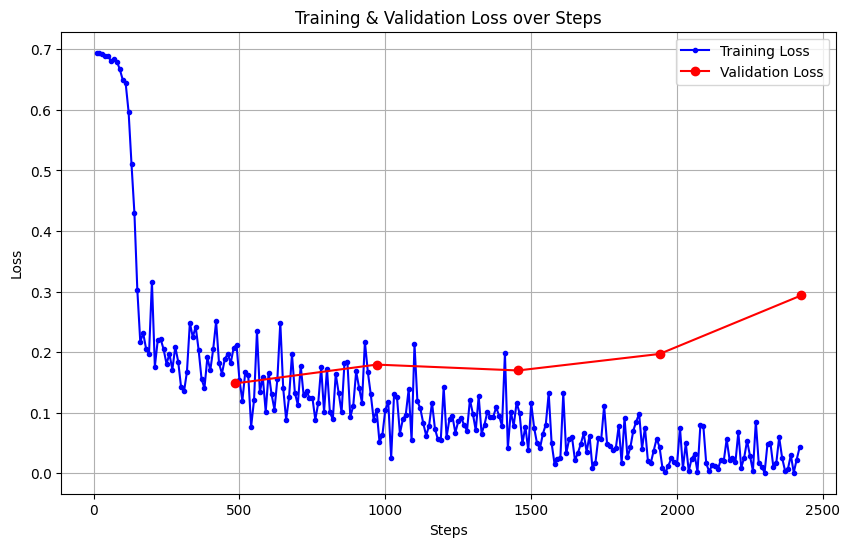

In [ ]:
import matplotlib.pyplot as plt

# 1. Trích xuất log history
log_history = trainer.state.log_history

train_loss = []
train_steps = []
eval_loss = []
eval_steps = []

for entry in log_history:
    if 'loss' in entry:
        train_loss.append(entry['loss'])
        train_steps.append(entry['step'])
    if 'eval_loss' in entry:
        eval_loss.append(entry['eval_loss'])
        eval_steps.append(entry['step'])

# 2. Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss, label='Training Loss', color='blue', marker='.')
plt.plot(eval_steps, eval_loss, label='Validation Loss', color='red', marker='o')

plt.title('Training & Validation Loss over Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Đánh giá mô hình

Đang đánh giá trên tập Test...



=== Classification Report ===
               precision    recall  f1-score   support

    Toxic (0)     0.9745    0.9307    0.9521       779
Non-toxic (1)     0.9547    0.9836    0.9689      1158

     accuracy                         0.9623      1937
    macro avg     0.9646    0.9571    0.9605      1937
 weighted avg     0.9627    0.9623    0.9622      1937



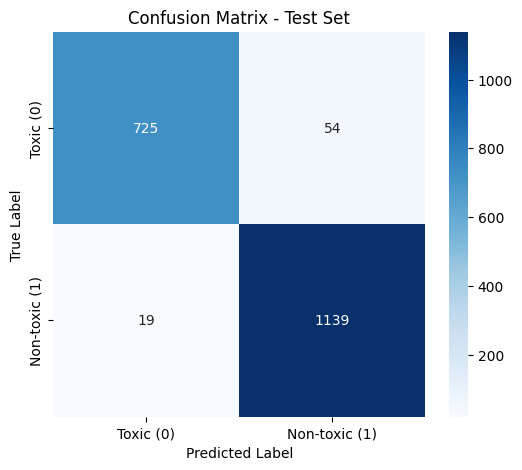


=== Metrics tổng hợp ===
{'test_loss': 0.16367726027965546, 'test_accuracy': 0.9623128549303046, 'test_precision': 0.9547359597652976, 'test_recall': 0.9835924006908463, 'test_f1': 0.968949383241174, 'test_specificity': 0.9306803594351734, 'test_precision_class_0': 0.9744623655913979, 'test_recall_class_0': 0.9306803594351734, 'test_f1_class_0': 0.9520682862770847, 'test_precision_class_1': 0.9547359597652976, 'test_recall_class_1': 0.9835924006908463, 'test_f1_class_1': 0.968949383241174, 'test_true_negative': 725, 'test_false_positive': 54, 'test_false_negative': 19, 'test_true_positive': 1139, 'test_runtime': 19.9767, 'test_samples_per_second': 96.963, 'test_steps_per_second': 6.107}


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# 1. Dự đoán trên tập Test
print("Đang đánh giá trên tập Test...")
predict_result = trainer.predict(test_ds)

# 2. Lấy nhãn dự đoán và nhãn thực tế
logits = predict_result.predictions
y_pred = np.argmax(logits, axis=-1)
y_true = predict_result.label_ids

# 3. In Classification Report
target_names = ["Toxic (0)", "Non-toxic (1)"]
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

# 4. Vẽ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.show()

# 5. In các metric tổng hợp từ trainer
print("\n=== Metrics tổng hợp ===")
print(predict_result.metrics)

In [ ]:
# Lưu mô hình
trainer.save_model(MODELS)
tokenizer.save_pretrained(MODELS)

('/content/drive/MyDrive/NLP/FinalTerm/Encoder_only/Datasets/Models/tokenizer_config.json',
 '/content/drive/MyDrive/NLP/FinalTerm/Encoder_only/Datasets/Models/special_tokens_map.json',
 '/content/drive/MyDrive/NLP/FinalTerm/Encoder_only/Datasets/Models/vocab.txt',
 '/content/drive/MyDrive/NLP/FinalTerm/Encoder_only/Datasets/Models/bpe.codes',
 '/content/drive/MyDrive/NLP/FinalTerm/Encoder_only/Datasets/Models/added_tokens.json')

# Inference

In [8]:
import torch
model = AutoModelForSequenceClassification.from_pretrained(MODELS)
tokenizer = AutoTokenizer.from_pretrained(MODELS)
model.eval()

# Test
text = "Con mèo nhà bạn đâu?"
inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256)
outputs = model(**inputs)
prediction = torch.argmax(outputs.logits, dim=-1)
id2label = {
    0: "toxic",
    1: "non-toxic"
}
prediction = id2label[prediction.item()]
print(prediction)

non-toxic
